In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

In [2]:
df = pd.read_csv(r'C:\Users\100346\OneDrive - Pantaleon. S.A\Desktop\DataScience\El Niño\ONI_timeseries.csv')
df.head()

,Date,ONI
0,1950-01,-1.5
1,1950-02,-1.3
2,1950-03,-1.2
3,1950-04,-1.2
4,1950-05,-1.1


In [3]:
# Escalamiento del ONI
scaler = MinMaxScaler()

# Formateo para el escalador
ONI = df.ONI.values.reshape(-1, 1)
y = scaler.fit_transform(ONI)

In [10]:
# generate the input and output sequences
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 24  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

In [11]:
# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X, Y, epochs=50, batch_size=16, shuffle=False, validation_split=0.2)

Epoch 1/50
40/40 [==============================] - 4s 40ms/step - loss: 0.0879 - val_loss: 0.0374
Epoch 2/50
40/40 [==============================] - 1s 25ms/step - loss: 0.0360 - val_loss: 0.0355
Epoch 3/50
40/40 [==============================] - 1s 25ms/step - loss: 0.0344 - val_loss: 0.0351
Epoch 4/50
40/40 [==============================] - 1s 25ms/step - loss: 0.0339 - val_loss: 0.0349
Epoch 5/50
40/40 [==============================] - 1s 25ms/step - loss: 0.0335 - val_loss: 0.0347
Epoch 6/50
40/40 [==============================] - 1s 25ms/step - loss: 0.0332 - val_loss: 0.0344
Epoch 7/50
40/40 [==============================] - 1s 26ms/step - loss: 0.0329 - val_loss: 0.0341
Epoch 8/50
40/40 [==============================] - 1s 26ms/step - loss: 0.0325 - val_loss: 0.0337
Epoch 9/50
40/40 [==============================] - 1s 26ms/step - loss: 0.0321 - val_loss: 0.0331
Epoch 10/50
40/40 [==============================] - 1s 26ms/step - loss: 0.0317 - val_loss: 0.0324
Epoch 11/

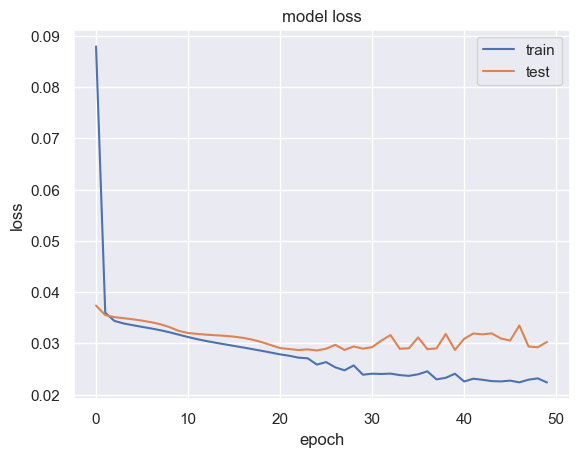

In [12]:
# Resumen de Optimización por RMSE
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [13]:
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

1/1 [==============================] - 1s 507ms/step


In [14]:
# organize the results in a data frame
df_past = df
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past.rename(columns={'ONI': 'Actual'}, inplace=True)
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_past

,Date,Actual,Forecast
0,1950-01-01,-1.5,NaN
1,1950-02-01,-1.3,NaN
2,1950-03-01,-1.2,NaN
3,1950-04-01,-1.2,NaN
4,1950-05-01,-1.1,NaN
...,...,...,...
873,2022-10-01,-1.0,NaN
874,2022-11-01,-0.9,NaN
875,2022-12-01,-0.8,NaN
876,2023-01-01,-0.7,NaN


C:\Users\sbarrios\AppData\Local\Temp\ipykernel_18928\2797988918.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('Date')


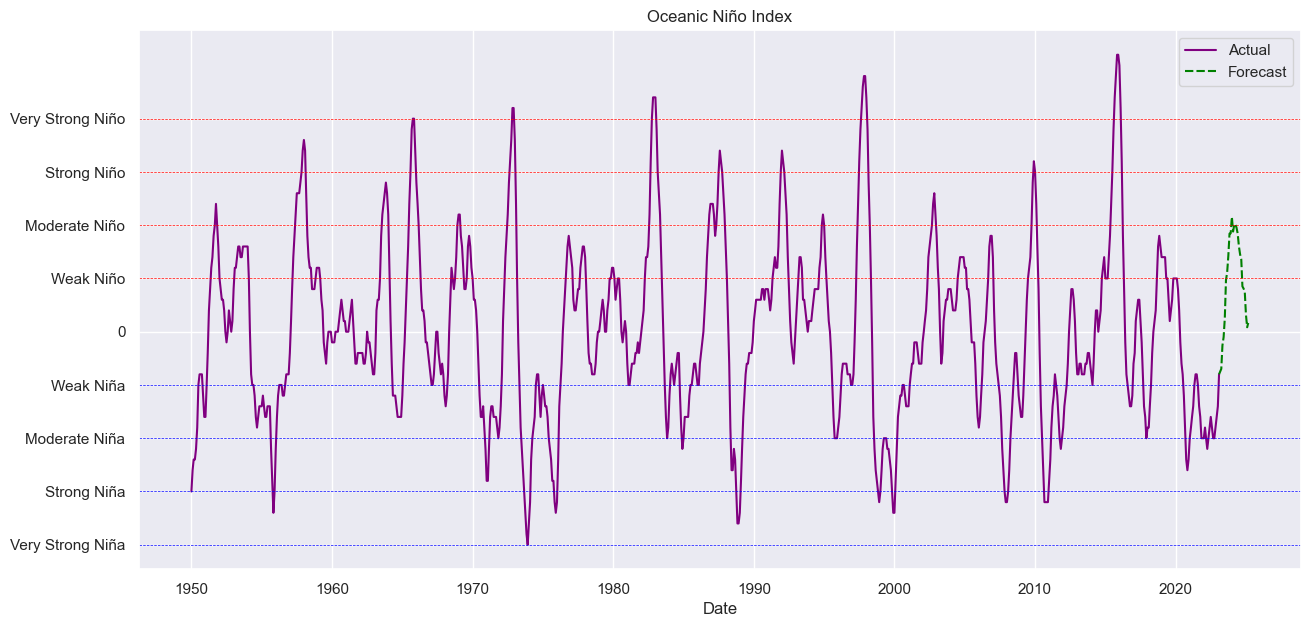

In [26]:
df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
inicio = df_past['Date'].iloc[-1] + pd.DateOffset(months=1)
df_future['Date'] = pd.date_range(start=inicio, periods=n_forecast, freq='M')
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan
df_future

# Concatenando Histórico y Predicción a 30 meses
results = df_past.append(df_future).set_index('Date')


# Gráfico de Resultados
#results.plot(title='Oceanic Niño Index', figsize = (15,7))
sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
plt.figure(figsize=(15,7))
sns.set_style("darkgrid")
graph = sns.lineplot(data = results, palette=['purple', 'green']).set(title='Oceanic Niño Index')

plt.axhline(2.0,color='red',linestyle='--',linewidth = 0.5)
plt.axhline(1.5,color='red',linestyle='--',linewidth = 0.5)
plt.axhline(1.0,color='red',linestyle='--',linewidth = 0.5)
plt.axhline(0.5,color='red',linestyle='--',linewidth = 0.5)
plt.axhline(-0.5,color='blue',linestyle='--',linewidth = 0.5)
plt.axhline(-1.0,color='blue',linestyle='--',linewidth = 0.5)
plt.axhline(-1.5,color='blue',linestyle='--',linewidth = 0.5)
plt.axhline(-2.0,color='blue',linestyle='--',linewidth = 0.5)

plt.yticks([2.0, 1.5, 1.0, 0.5, 0, -2.0, -1.5, -1.0, -0.5], ['Very Strong Niño', 'Strong Niño', 'Moderate Niño', 'Weak Niño','0','Very Strong Niña', 'Strong Niña', 'Moderate Niña', 'Weak Niña'])

plt.show()

In [27]:
# Print the output.
results.to_csv(r'C:\Users\sbarrios\OneDrive - Universidad Galileo\Data Science\Python\Proyectos\Pruebas\Pantaleon\Clima\Prediccion_ONI.csv')